In [1]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Importing plotly failed. Interactive plots will not work.


In [28]:
# 读取CSV文件
df = pd.read_csv('bitcoin_price_sentiment.csv')

# 确保日期列是datetime格式
df['date'] = pd.to_datetime(df['date'])

# 准备Prophet所需的数据框
prophet_df = df[['date', 'Close']].rename(columns={'date': 'ds', 'Close': 'y'})

# prophet_df = df[['date', 'Close', 'sentiment_scores']].rename(columns={'date': 'ds', 'Close': 'y'})

# 添加其他特征作为回归变量
# features = ['Open', 'High', 'Low', 'Volume', 'sentiment_scores']

features = ['sentiment_scores']

# 标准化特征
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# 将特征添加到prophet_df
for feature in features:
    prophet_df[feature] = df[feature]

# 分割数据为训练集和测试集
# train_df, test_df = train_test_split(prophet_df, test_size=0.3, shuffle=False)

12:09:27 - cmdstanpy - INFO - Chain [1] start processing
12:09:27 - cmdstanpy - INFO - Chain [1] done processing


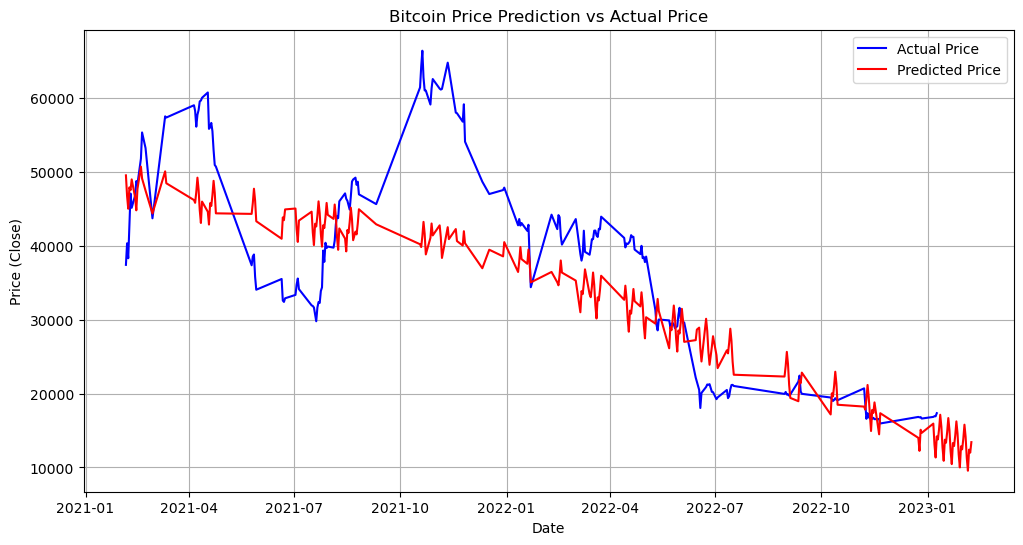

In [29]:
# 创建Prophet模型
model = Prophet()

# 添加所有特征作为回归变量
for feature in features:
    model.add_regressor(feature)

# 训练模型
model.fit(prophet_df)

# 创建未来30天的日期范围
future_dates = model.make_future_dataframe(periods=30)

# 为未来日期添加特征值
# 这里我们使用最后一个已知的值，你可能需要根据实际情况调整这个逻辑
for feature in features:
    future_dates[feature] = df[feature].iloc[-1]

# 进行预测
forecast = model.predict(future_dates)

# 读取预测结果中的 ds（日期）和 yhat（预测值）字段
forecast_filtered = forecast[['ds', 'yhat']]

# 将实际价格数据与预测结果合并
df_merged = pd.merge(forecast_filtered, prophet_df, on='ds', how='left')

# 绘制实际价格和预测价格的对比图
plt.figure(figsize=(12, 6))

# 画出实际价格的折线图
plt.plot(df_merged['ds'], df_merged['y'], label='Actual Price', color='blue')

# 画出预测价格的折线图
plt.plot(df_merged['ds'], df_merged['yhat'], label='Predicted Price', color='red')

# 添加图例和标题
plt.legend()
plt.title('Bitcoin Price Prediction vs Actual Price')
plt.xlabel('Date')
plt.ylabel('Price (Close)')
plt.grid(True)
plt.show()

In [30]:
# 预测已知的历史数据
historical_forecast = model.predict(prophet_df)

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# 获取实际值和预测值
y_true = prophet_df['y'].values  # 实际值
y_pred = historical_forecast['yhat'].values  # 预测值

# 计算均方误差 (MSE)
mse = mean_squared_error(y_true, y_pred)

# 计算均方根误差 (RMSE)
rmse = np.sqrt(mse)

# 计算平均绝对误差 (MAE)
mae = mean_absolute_error(y_true, y_pred)

# 计算决定系数 R²
r2 = r2_score(y_true, y_pred)

# 打印结果
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

MSE: 60980869.95193458
RMSE: 7809.02490404113
MAE: 5980.871868771956
R²: 0.6777939846865725
